토크나이징을 위하여 cohesion을 학습할 것인지, 문서들을 토크나이징 할 것인지 미리 지정합니다. 

토크나이징과 같이 작업 시간이 많이 들어갈 수 있는 작업들은 이렇게 맨 위에서 True, False로 설정할 수 있도록 미리 설정해두면, Shift + Enter를 연속으로 누르다가 했던 작업을 다시 하는 실수를 방지할 수 있습니다. 

한 번 학습을 하고나면 값을 False로 바꿔두세요. 

우리는 지난 시간에 토크나이징을 모두 끝내둔 'data/sample_naver_movie/merged_comments_tokenized.txt' 파일을 이용하겠습니다. 

In [38]:
import soynlp

corpus_fname = './data/merged_movie_comments.txt'
tokenized_corpus_fname = './data/merged_movie_comments_tsoynlp.txt.txt'


TRAIN_WORD2VEC = False
word2vec_fname = './data/movie_review_word2vec_model_v2.2.pkl'


TRAIN_DOC2VEC = False
doc2vec_fname = './data/movie_review_doc2vec_model_v2.2.pkl'

id2movie_fname = './data/navermovie_info_idx2moviename.pkl'
id2actor_fname = './data/navermovie_info_idx2actorname.pkl'

## Preprocessing: Cohesion training + Tokenizing

corpus 파일은 tap으로 구분하여 한 줄에 <영화아이디, 텍스트, 평점>으로 입력되어 있습니다. 

    with open() as f:
        docs=[doc.strip().split('\t') for doc in f]

위 구문은 파일을 읽어 한 줄에 줄바꿈 기호를 제거한 뒤, tap으로 줄을 분리합니다. 그 결과 한 줄에는 [영화아이디, 텍스트, 평점]의 리스트가 들어있게 됩니다. 

    [[영화아이디, 텍스트, 평점], 
     [영화아이디, 텍스트, 평점], 
     ...
    ]

위 형식의 list of list이기 때문에 각각의 column 별로 값을 분리하기 위하여 zip(\*)을 이용합니다. 

In [4]:
def get_text(fname):
    with open(fname, encoding='utf-8') as f:
        docs = [doc.strip().split('\t') for doc in f]
    
    idx, texts, scores = zip(*docs)
    return idx, texts, scores

idx, docs, scores = get_text(tokenized_corpus_fname)
docs[:5]

('명불허전',
 '왠지 고사 피의 중간 고사 보다 재미 가 없을 듯해요 만약 보게 된다 면 실망 할듯',
 '티아라 사랑 해 ㅜ',
 '황정 음 윤시윤 지붕킥 인연 김수 로 티아라지연 공부 의신 인연 너무 너무 재미 있어 요',
 '기대 완전')

문서의 길이는 3,280,685 입니다. 320만개 정도의 리뷰가 있습니다

In [3]:
len(docs)

3280685

## Gensim version

gensim이 버전업데이트를 최근에 자주해서, 자료의 gensim version을 미리 적어둡니다. 

In [94]:
import gensim
gensim.__version__

'2.2.0'

## Word2Vec 학습

Gensim의 Word2Vec을 학습하기 위해서는 list of str 형식의 input이 필요합니다. 하지만 모든 리뷰들을 메모리에 올리지 않고도 학습할 수 있습니다. generator인 with open을 이용하여 \__iter\__를 오버라이딩한 CommentWord2Vec이라는 클래스를 생성합니다. 

\__iter\__에서 

    for doc in f:
        movie_idx, text, score = doc.split('\t')
        yield text.split()

을 수행하면, 파일 f로부터 한 줄을 읽어 tap으로 텍스트를 구분한 뒤, 그 텍스트를 띄어쓰기 기준으로 잘라낸 token list가 for loop 안에서 출력됩니다. 

\__iter\__는 아래 구문이 작동할 수 있도록 해주는 파이썬 내장함수 입니다. 

    for doc in word2vec_corpus:
        print(doc)

토크나이징이 된 리뷰들을 CommentWord2Vec의 fname으로 입력하였기 때문에, 띄어쓰기 만으로 단어열을 yield 할 수 있습니다. 이러한 작업은 반복이 되기 때문에 raw corpus와 tokenized corpus를 구분하여 저장하는 것이 좋습니다. 

In [5]:
import os
    
class CommentWord2Vec:
    
    def __init__(self, fname):
        self.fname = fname
        if not os.path.exists(fname):
            print('File not found: %s' % fname)
        
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield text.split()
                
                
word2vec_corpus = CommentWord2Vec(tokenized_corpus_fname)

for num_doc, doc in enumerate(word2vec_corpus):
    if num_doc > 5: break
    print(doc)

['명불허전']
['왠지', '고사', '피의', '중간', '고사', '보다', '재미', '가', '없을', '듯해요', '만약', '보게', '된다', '면', '실망', '할듯']
['티아라', '사랑', '해', 'ㅜ']
['황정', '음', '윤시윤', '지붕킥', '인연', '김수', '로', '티아라지연', '공부', '의신', '인연', '너무', '너무', '재미', '있어', '요']
['기대', '완전']
['기대', '지연', '나온다']


Gensim의 Word2Vec을 이용합니다. 미리 만들어둔 word2vec_corpus를 Word2Vec의 argument로 입력합니다. default parameters를 이용하여 Word2Vec을 학습힙니다. 

Word2Vec의 arguments 중에서 중요한 것들은 아래와 같습니다. 

- size: 단어의 임베딩 공간의 크기
- alpha: learning rate
- window: 한 단어의 좌/우의 문맥 크기
- min_count: 모델이 학습할 단어의 최소 출현 빈도수
- max_vocab_size: None이 아닌 숫자를 입력하면 빈도수 기준으로 상위 max_vocab_size 개수만큼의 단어만 학습
- sg: 1이면 skipgram 이용
- negative: negative sampling에서 negative sample의 개수

- 학습시간: 7min 20 sec (i7-5820, n_workers=3)

In [10]:
from gensim.models import Word2Vec
import pickle

if TRAIN_WORD2VEC:
    word2vec_model = Word2Vec(word2vec_corpus,
                              size=100,
                              alpha=0.025,
                              window=5,
                              min_count=5,
                              sg=0,
                              negative=5)
    with open(word2vec_fname, 'wb') as f:
        pickle.dump(word2vec_model, f)
        
else:
    with open(word2vec_fname, 'rb') as f:
        word2vec_model = pickle.load(f)

학습된 Word2Vec모델의 .most_similar(단어, topn) 함수는 입력된 단어에 대하여 가장 비슷한 topn개의 다른 단어들과 유사도를 출력합니다. 

아래의 에제에서 '영화'와 가장 비슷한 단어는 '애니'이며, 유사도는 0.7440입니다

In [19]:
word2vec_model.most_similar('영화', topn=10)

[('애니', 0.7440013885498047),
 ('애니메이션', 0.6863694787025452),
 ('작품', 0.6436028480529785),
 ('명화', 0.6181749701499939),
 ('드라마', 0.6173965930938721),
 ('에니메이션', 0.5842347145080566),
 ('수작', 0.5821621417999268),
 ('블록버스터', 0.5791249871253967),
 ('여화', 0.5710904598236084),
 ('영호ㅏ', 0.566919207572937)]

In [20]:
word2vec_model.most_similar('하정우', topn=10)

[('송강호', 0.9009091854095459),
 ('이정재', 0.868990421295166),
 ('공유', 0.8560090661048889),
 ('황정민', 0.8337357044219971),
 ('유아인', 0.820427656173706),
 ('설경구', 0.811323881149292),
 ('송광호', 0.8103774189949036),
 ('윌스미스', 0.8072429299354553),
 ('박해일', 0.803587794303894),
 ('손현주', 0.7990751266479492)]

1점과 유사한 단어가 한글로 쓴 '일점', 그 이후로는 1, 2, 3, ... 이렇게 점수가 멀어져가는 것도 볼 수 있습니다

In [21]:
word2vec_model.most_similar('1점', topn=10)

[('일점', 0.9020614624023438),
 ('별1개', 0.8623889088630676),
 ('별반개', 0.8478377461433411),
 ('2점', 0.8468687534332275),
 ('별한개', 0.8328550457954407),
 ('3점', 0.8136663436889648),
 ('5점', 0.7921497821807861),
 ('4점', 0.77998948097229),
 ('십점', 0.7688029408454895),
 ('반점', 0.7538278102874756)]

'십점' 이라는 말은 점수가 들어갈 수 있는 문맥에서 나오는 말이기도 하지만, 긍정적인 표현에서 더 많이 나왔을 것입니다. 그렇기 때문에 1점 보다도, 천점, 백점 같은 단어들이 더 유사하게 학습됩니다 (네이버 영화에서 10점은 별 다섯개입니다)

In [22]:
word2vec_model.most_similar('십점', topn=10)

[('백점', 0.8095669150352478),
 ('별다섯개', 0.788926362991333),
 ('별5개', 0.7856196761131287),
 ('1점', 0.7688029408454895),
 ('일점', 0.7421482801437378),
 ('구점', 0.728834331035614),
 ('만점', 0.7254747152328491),
 ('반점', 0.7221064567565918),
 ('백점만점', 0.7200658321380615),
 ('최하점', 0.7146005034446716)]

평론가는 평론가, 평론 단체 (씨네21 등)끼리 뭉쳐 나오는 걸 볼 수 있습니다

In [23]:
word2vec_model.most_similar('이동진', topn=10)

[('황진미', 0.8715710043907166),
 ('김현수', 0.8565118312835693),
 ('송경원', 0.8540835976600647),
 ('박평식', 0.8316025137901306),
 ('이용철', 0.8274370431900024),
 ('허남웅', 0.7955989241600037),
 ('허지웅', 0.7936883568763733),
 ('정시우', 0.7867159843444824),
 ('씨네21', 0.7795636057853699),
 ('한겨레', 0.7658989429473877)]

In [25]:
word2vec_model.most_similar('평론가', topn=10)

[('전문가', 0.8642435073852539),
 ('기자', 0.861341118812561),
 ('씨네21', 0.8071532845497131),
 ('평론가들', 0.7693830728530884),
 ('기자들', 0.7190637588500977),
 ('일베', 0.7149430513381958),
 ('한겨레', 0.7123231887817383),
 ('평론', 0.7109761238098145),
 ('황진미', 0.710832417011261),
 ('시네21', 0.7034419775009155)]

In [26]:
word2vec_model.most_similar('평론', topn=10)

[('비평', 0.8239690661430359),
 ('비난', 0.7331878542900085),
 ('평가', 0.7235270738601685),
 ('평론가', 0.7109761238098145),
 ('악평', 0.7079919576644897),
 ('마녀사냥', 0.7037042379379272),
 ('판단', 0.6914525032043457),
 ('악플', 0.6832283735275269),
 ('잘난척', 0.6795428991317749),
 ('평론가들', 0.6750478744506836)]

In [27]:
word2vec_model.most_similar('스토리', topn=10)

[('줄거리', 0.8622268438339233),
 ('시나리오', 0.8560415506362915),
 ('내용', 0.7455657124519348),
 ('내러티브', 0.738810658454895),
 ('소재', 0.674518346786499),
 ('플롯', 0.6455096006393433),
 ('전개', 0.6317200660705566),
 ('CG', 0.6294261813163757),
 ('영상미', 0.6248971819877625),
 ('cg', 0.6024293303489685)]

In [28]:
word2vec_model.most_similar('조연', topn=10)

[('조연들', 0.8296752572059631),
 ('주연', 0.7533316016197205),
 ('단역', 0.7461921572685242),
 ('조연들의', 0.6941962242126465),
 ('배역', 0.5808011293411255),
 ('배역들', 0.5733293294906616),
 ('정재영', 0.5670306086540222),
 ('아역', 0.5601400136947632),
 ('곽도원', 0.5530614852905273),
 ('악역', 0.5424337387084961)]

In [29]:
word2vec_model.most_similar('배우', topn=10)

[('캐릭터', 0.7173871994018555),
 ('톱스타', 0.664429783821106),
 ('케릭터', 0.6501983404159546),
 ('주연', 0.5914883613586426),
 ('베우', 0.5758824348449707),
 ('아이', 0.5647087693214417),
 ('연기', 0.5622798204421997),
 ('조연들', 0.5591898560523987),
 ('주인공', 0.5577583312988281),
 ('꼬맹이', 0.5492199659347534)]

In [30]:
word2vec_model.most_similar('포디', topn=10)

[('4디', 0.8396525382995605),
 ('4d', 0.8351113200187683),
 ('4D', 0.816162109375),
 ('3디', 0.7893713712692261),
 ('2d', 0.7636864185333252),
 ('쓰리디', 0.7636334300041199),
 ('아이맥스', 0.7610283493995667),
 ('3d', 0.7568767070770264),
 ('imax', 0.7514917254447937),
 ('IMAX', 0.7417081594467163)]

In [31]:
word2vec_model.most_similar('영등포', topn=10)

[('용산', 0.9279516935348511),
 ('일산', 0.9147178530693054),
 ('센텀', 0.8986476063728333),
 ('왕십리', 0.8894186615943909),
 ('신도림', 0.879650890827179),
 ('신촌', 0.8731285929679871),
 ('롯데', 0.8690088987350464),
 ('메가박스', 0.8688494563102722),
 ('상암', 0.8638758063316345),
 ('부천', 0.8594379425048828)]

메가박스의 유사어로 롯데시네마가 잡히기도 하지만, **롯시**라는 약어도 학습됩니다. 토크나이징이 잘 되어 있다면, 이와 같이 예상하지 못하는 단어도 비슷한 단어로 학습될 수 있습니다. 

In [32]:
word2vec_model.most_similar('메가박스', topn=20)

[('롯데', 0.8768852353096008),
 ('영등포', 0.8688493967056274),
 ('일산', 0.8619153499603271),
 ('시네마', 0.8605634570121765),
 ('동대문', 0.8526878356933594),
 ('센텀', 0.8327674865722656),
 ('신촌', 0.8327223658561707),
 ('용산', 0.8300974369049072),
 ('왕십리', 0.8124370574951172),
 ('강남역', 0.8095139265060425),
 ('부천', 0.80931156873703),
 ('홍대', 0.8017978668212891),
 ('목동', 0.7993530035018921),
 ('노원', 0.7943507432937622),
 ('9시', 0.7920055389404297),
 ('김포공항', 0.7910195589065552),
 ('씨너스', 0.7886525988578796),
 ('상암', 0.7883567810058594),
 ('강변', 0.7761704921722412),
 ('롯시', 0.7746952176094055)]

당연히 Word2Vec 입장에서는 언어가 섞여 씌여도 관계가 없습니다. 

In [33]:
word2vec_model.most_similar('ocn', topn=10)

[('OCN', 0.8428668975830078),
 ('케이블', 0.7475681304931641),
 ('tv', 0.7423914670944214),
 ('지상파', 0.7315957546234131),
 ('KBS', 0.7230730056762695),
 ('파일', 0.7212100625038147),
 ('체널', 0.7208391427993774),
 ('아맥', 0.7183413505554199),
 ('TV', 0.7181311845779419),
 ('특집', 0.7104942798614502)]

In [35]:
word2vec_model.most_similar('황정민')

[('김윤석', 0.91635662317276),
 ('김명민', 0.9074050188064575),
 ('조진웅', 0.8827342391014099),
 ('정재영', 0.8794874548912048),
 ('유해진', 0.8780785799026489),
 ('유아인', 0.8684196472167969),
 ('최민식', 0.8521925210952759),
 ('송강호', 0.8493781089782715),
 ('이선균', 0.8468509912490845),
 ('손예진', 0.845827043056488)]

Word2Vec model의 단어 벡터들은 Word2Vec.wv 아래에 저장되어 있습니다. gensim version 1.x 부터 Word2Vec.wv에서 단어 벡터를 따로 관리합니다.
    
    
### Word2Vec.wv.syn0: 실제 단어가 저장되어 있는 행렬    

우리는 size=100으로 74,643개의 단어를 학습하였기 때문에 sync0의 shape은 아래와 같습니다.

    word2vec_model.wv.syn0.shape    
    > (74643, 100)

### Word2Vec.wv.syn0norm: cosine similarity를 위하여 row normalize를 한 행렬로 모양은 같지만, 벡터의 2 Norm이 1입니다. 

    > word2vec_model.wv.syn0norm.shape
    (74643, 100)
    
    > sum((v**2 for v in word2vec_model.wv.syn0[0]))
    308.73273480277481
    
    > sum((v**2 for v in word2vec_model.wv.syn0norm[0]))
    1.000000082656431


Word2Vec.wv.index2word는 단어별 index가 저장되어 있습니다. 

In [52]:
type(word2vec_model.wv.index2word)

list

In [53]:
word2vec_model.wv.index2word[0]

'영화'

단어 벡터를 가져오려면 아래코드 중 하나를 실행하면 됩니다. 

    word2vec_model.wv['영화'] # 2.2 부터의 인터페이스
    
    word2vec_model['영화']    # 0.9.x 에서의 인터페이스

In [55]:
word2vec_model.wv['영화']

array([-0.91994137, -1.61856759,  1.90144312,  0.98856968, -0.4734728 ,
       -1.2333827 ,  1.81848848, -0.21094997,  1.50755954, -0.64310944,
       -2.87900949, -0.86661887, -1.06520545, -0.69794244,  0.35853487,
        1.4254837 ,  1.5765816 ,  0.34574485, -0.6596753 , -1.14894986,
       -2.24943042,  0.8821013 , -3.49409723,  1.70316768,  3.35510468,
        1.45350969, -0.20231712, -2.61010456,  1.02500618,  1.93765879,
        1.87924516, -0.09029722, -1.81159067,  0.70364046, -0.86877525,
        0.98927134, -1.66022921,  0.78950971,  1.05217767, -3.98992515,
       -0.50905228,  2.37688541, -1.83175969, -0.87833279,  0.93759656,
       -1.07104349,  0.34908211,  0.25865617, -2.66913509, -1.15528643,
       -2.30407071, -0.97630799, -2.30921602,  1.17665911, -0.43932977,
       -1.79386759,  1.65109384,  0.49195492, -0.82937878,  0.73720664,
       -0.55745018, -0.99580437,  0.5174197 ,  0.3120977 , -2.43742275,
        2.63843203, -0.52643317,  0.44590622, -1.1393019 , -0.94

In [54]:
word2vec_model['영화']

array([-0.91994137, -1.61856759,  1.90144312,  0.98856968, -0.4734728 ,
       -1.2333827 ,  1.81848848, -0.21094997,  1.50755954, -0.64310944,
       -2.87900949, -0.86661887, -1.06520545, -0.69794244,  0.35853487,
        1.4254837 ,  1.5765816 ,  0.34574485, -0.6596753 , -1.14894986,
       -2.24943042,  0.8821013 , -3.49409723,  1.70316768,  3.35510468,
        1.45350969, -0.20231712, -2.61010456,  1.02500618,  1.93765879,
        1.87924516, -0.09029722, -1.81159067,  0.70364046, -0.86877525,
        0.98927134, -1.66022921,  0.78950971,  1.05217767, -3.98992515,
       -0.50905228,  2.37688541, -1.83175969, -0.87833279,  0.93759656,
       -1.07104349,  0.34908211,  0.25865617, -2.66913509, -1.15528643,
       -2.30407071, -0.97630799, -2.30921602,  1.17665911, -0.43932977,
       -1.79386759,  1.65109384,  0.49195492, -0.82937878,  0.73720664,
       -0.55745018, -0.99580437,  0.5174197 ,  0.3120977 , -2.43742275,
        2.63843203, -0.52643317,  0.44590622, -1.1393019 , -0.94

Word2Vec에서 index2word의 단어 순서는 단어의 빈도순입니다. 단어에 관련된 정보를 가져오고 싶다면 Word2Vec.wv.vocab을 이용하세요. 

vocab은 {단어: Vocab} 형식의 dict입니다. Vocab은 namedtuple이기 때문에 아래와 같이 이용할 수 있습니다. 

    word2vec_model.wv.vocab['영화'].count

In [56]:
word2vec_model.wv.vocab['영화']

In [57]:
str(word2vec_model.wv.vocab['영화'])

'Vocab(count:1412516, index:0, sample_int:891300489)'

In [64]:
word2vec_model.wv.vocab['영화'].count

1412516

영화 다음으로 많이 등장한 단어인 ['이', '관람객']에 대한 정보도 가져와봅니다. index는 index2word의 index입니다. 

In [61]:
word2vec_model.wv.index2word[1], word2vec_model.wv.index2word[2]

('이', '관람객')

In [63]:
print(str(word2vec_model.wv.vocab['이']))
print(str(word2vec_model.wv.vocab['관람객']))

Vocab(count:764006, index:1, sample_int:1277286636)
Vocab(count:585858, index:2, sample_int:1498673726)


## Doc2Vec 학습

Doc2Vec을 학습하기 위해서는 각각 문서의 label이 저장되어야 합니다. 이를 위하여 TaggedDocument라는 클래스가 이용됩니다. TaggedDocument는 단어들을 words에, 레이블 정보를 tags에 리스트 형태로 입력합니다

- 학습시간 (i7-5820): 20min 54s

In [37]:
import os
import pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


class CommentDoc2Vec:
    
    def __init__(self, fname):
        self.fname = fname
        if not os.path.exists(fname):
            print('File not found: %s' % fname)
        
    def __iter__(self):
        with open(self.fname, encoding='utf-8') as f:
            for doc in f:
                movie_idx, text, score = doc.split('\t')
                yield TaggedDocument(words=text.split(), tags=['MOVIE_%s' % movie_idx])

                
doc2vec_corpus = CommentDoc2Vec(tokenized_corpus_fname)


if TRAIN_DOC2VEC:
    doc2vec_model = Doc2Vec(doc2vec_corpus)
    with open(doc2vec_fname, 'wb') as f:
        pickle.dump(doc2vec_model, f)

else:
    with open(doc2vec_fname, 'rb') as f:
        doc2vec_model = pickle.load(f)

CPU times: user 28min 3s, sys: 3min 30s, total: 31min 33s
Wall time: 20min 54s


    Signature: doc2vec_model.infer_vector(doc_words, alpha=0.1, min_alpha=0.0001, steps=5)
    Docstring:
    Infer a vector for given post-bulk training document.

    Document should be a list of (word) tokens.

In [39]:
doc2vec_model.infer_vector?

Doc2Vec은 Word2Vec과 동일하게 단어 벡터를 학습하며, 이를 바탕으로 document vector를 학습합니다. 그렇기 때문에 단어 벡터에 의한 유사도는 동일하게 학습됩니다. 

In [40]:
doc2vec_model.most_similar('영화', topn=10)

[('영회', 0.6946662068367004),
 ('양화', 0.6887550950050354),
 ('애니', 0.6820842623710632),
 ('엉화', 0.6614311933517456),
 ('여화', 0.6360124945640564),
 ('애니메이션', 0.6320168972015381),
 ('영호ㅏ', 0.6210547685623169),
 ('연화', 0.5999889969825745),
 ('에니메이션', 0.5683504939079285),
 ('영호ㅓ', 0.5612629055976868)]

Doc2Vec model의 .docvecs안에는 document vector와 관련된 정보들이 저장되어 있습니다

In [45]:
len(doc2vec_model.docvecs)

172

Doctags에 들어있는 offset은 document vector의 임베딩 메트릭스의 row id이며, word_count는 각 태그에 해당하는 문서에 단어가 몇 개 있었는지, doc_count는 각 태그에 해당하는 문서가 몇 번 등장하였는지입니다

In [41]:
for idx, doctag in sorted(doc2vec_model.docvecs.doctags.items(), key=lambda x:x[1].offset):
    print(idx, doctag)

MOVIE_72523 Doctag(offset=0, word_count=94513, doc_count=10187)
MOVIE_59845 Doctag(offset=1, word_count=144494, doc_count=13095)
MOVIE_109753 Doctag(offset=2, word_count=202367, doc_count=10361)
MOVIE_45321 Doctag(offset=3, word_count=294482, doc_count=26915)
MOVIE_45290 Doctag(offset=4, word_count=775777, doc_count=48273)
MOVIE_47385 Doctag(offset=5, word_count=412600, doc_count=41653)
MOVIE_78726 Doctag(offset=6, word_count=326349, doc_count=20615)
MOVIE_89218 Doctag(offset=7, word_count=388191, doc_count=20080)
MOVIE_47528 Doctag(offset=8, word_count=139339, doc_count=13397)
MOVIE_75397 Doctag(offset=9, word_count=236332, doc_count=16444)
MOVIE_48246 Doctag(offset=10, word_count=235112, doc_count=21912)
MOVIE_140695 Doctag(offset=11, word_count=318897, doc_count=23998)
MOVIE_72054 Doctag(offset=12, word_count=378347, doc_count=25748)
MOVIE_102817 Doctag(offset=13, word_count=386768, doc_count=26021)
MOVIE_109960 Doctag(offset=14, word_count=256567, doc_count=14302)
MOVIE_123519 Doct

위에서 MOVIE_59845의 offset = 1은 docvec에서의 row id가 1라는 의미입니다. 

리스트 안의 tuple 값의 의미는 (doctag, 유사도) 입니다 

In [65]:
doc2vec_model.docvecs.most_similar('MOVIE_59845')

[('MOVIE_72408', 0.8431919813156128),
 ('MOVIE_45232', 0.7934122681617737),
 ('MOVIE_42589', 0.7770787477493286),
 ('MOVIE_123519', 0.7739340662956238),
 ('MOVIE_73344', 0.7243151068687439),
 ('MOVIE_39894', 0.697256326675415),
 ('MOVIE_65674', 0.6836678385734558),
 ('MOVIE_39405', 0.6777067184448242),
 ('MOVIE_39841', 0.6764494180679321),
 ('MOVIE_68695', 0.671931266784668)]

Document vector의 row id로도 most_similar를 찾을 수 있습니다. 

In [66]:
doc2vec_model.docvecs.most_similar(1)

[('MOVIE_72408', 0.8431919813156128),
 ('MOVIE_45232', 0.7934122681617737),
 ('MOVIE_42589', 0.7770787477493286),
 ('MOVIE_123519', 0.7739340662956238),
 ('MOVIE_73344', 0.7243151068687439),
 ('MOVIE_39894', 0.697256326675415),
 ('MOVIE_65674', 0.6836678385734558),
 ('MOVIE_39405', 0.6777067184448242),
 ('MOVIE_39841', 0.6764494180679321),
 ('MOVIE_68695', 0.671931266784668)]

Dov2Veco.docvecs.doctags는 document vector의 각 row 기준으로 tag 정보가 저장되어 있습니다. 

In [67]:
list(doc2vec_model.docvecs.doctags)[:5]

['MOVIE_72523', 'MOVIE_59845', 'MOVIE_109753', 'MOVIE_45321', 'MOVIE_45290']

word_count는 해당 문서에 등장한 단어의 총 빈도수의 합이며, doc_count는 MOVIE\_%D 형식으로 입력된 TaggedDocument의 개수입니다. 우리 데이터에서는 영화별 리뷰 개수에 해당합니다. 

In [68]:
list(doc2vec_model.docvecs.doctags.items())[:5]

[('MOVIE_72523', Doctag(offset=0, word_count=94513, doc_count=10187)),
 ('MOVIE_59845', Doctag(offset=1, word_count=144494, doc_count=13095)),
 ('MOVIE_109753', Doctag(offset=2, word_count=202367, doc_count=10361)),
 ('MOVIE_45321', Doctag(offset=3, word_count=294482, doc_count=26915)),
 ('MOVIE_45290', Doctag(offset=4, word_count=775777, doc_count=48273))]

## Doc2Vec 해석하기

In [69]:
import pickle

with open(id2movie_fname, 'rb') as f:
    idx2movie = pickle.load(f)
    
movie2idx = {name:movie_idx for movie_idx, name in idx2movie.items()}

Doc2Vec.docvecs.most_similar에서는 태그로 구분되는 문서들에 대하여 유사한 다른 문서를 찾아줍니다. 

In [70]:
for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(similar)

('MOVIE_96379', 0.9090828895568848)
('MOVIE_92075', 0.8448772430419922)
('MOVIE_89755', 0.7290356755256653)
('MOVIE_66158', 0.7020918726921082)
('MOVIE_63513', 0.6952322721481323)
('MOVIE_118917', 0.6928815245628357)
('MOVIE_115622', 0.6873512268066406)
('MOVIE_100931', 0.679163932800293)
('MOVIE_129050', 0.6677015423774719)
('MOVIE_39636', 0.6675947308540344)


영화 아이디를 영화 제목으로 바꿔서 해석해봅시다

In [71]:
for doctag in doc2vec_model.docvecs.doctags:
    movie_idx = doctag.split('_')[1]
    name = idx2movie.get(movie_idx, -1)
    print(movie_idx, '\t', name)

72523 	 고사 두 번째 이야기: 교생실습
59845 	 박쥐
109753 	 해무
45321 	 해운대
45290 	 인터스텔라
47385 	 국가대표
78726 	 도둑들
89218 	 베를린
47528 	 해리 포터와 죽음의 성물 - 2부
75397 	 미스터 고
48246 	 7광구
140695 	 럭키
72054 	 다크 나이트 라이즈
102817 	 해적: 바다로 간 산적
109960 	 배트맨 대 슈퍼맨: 저스티스의 시작
123519 	 아가씨
78790 	 내가 살인범이다
129408 	 메이즈 러너: 스코치 트라이얼
62586 	 다크 나이트
122527 	 캡틴 아메리카: 시빌 워
51143 	 과속스캔들
39157 	 미녀는 괴로워
141104 	 터널
51708 	 영웅: 샐러멘더의 비밀
137377 	 응답하라 1988
127496 	 대호
91031 	 신세계
121051 	 곡성(哭聲)
100931 	 겨울왕국
80866 	 완득이
109911 	 빅 히어로
52515 	 인셉션
18847 	 타이타닉
47384 	 26년
39636 	 지금, 만나러 갑니다
121048 	 암살
51386 	 포화 속으로
118917 	 인턴
52548 	 의형제
132933 	 판도라
120157 	 검은 사제들
72408 	 악마를 보았다
65674 	 좋은 놈, 나쁜 놈, 이상한 놈
106850 	 천안함 프로젝트
74866 	 인디펜던스 데이: 리써전스
93028 	 용의자
83893 	 광해, 왕이 된 남자
144968 	 제이슨 본
43679 	 캐리비안의 해적 - 세상의 끝에서
130013 	 님아, 그 강을 건너지 마오
70241 	 트랜스포머 3
118922 	 카트
77128 	 배틀쉽
130903 	 검사외전
102875 	 국제시장
67786 	 쥬라기 월드
93728 	 관상
44529 	 해바라기
99714 	 엑스맨: 데이즈 오브 퓨처 패스트
91073 	 박수건달
72522 	 감기
83084 	 최종병기 활
7431

영화 리뷰를 기준으로 각 영화를 document vector로 표현하였을 때 라라랜드와 리뷰가 비슷한 영화는 '비긴 어게인', '어바웃 타임' 등입니다

In [72]:
def id2name(similar):
    idx = similar[0].split('_')[1]
    return (idx2movie.get(idx, 'unknown'), idx, similar[1])


print('라라랜드\n')

for similar in doc2vec_model.docvecs.most_similar('MOVIE_134963'):
    print(id2name(similar))

라라랜드

('비긴 어게인', '96379', 0.9090828895568848)
('어바웃 타임', '92075', 0.8448772430419922)
('레미제라블', '89755', 0.7290356755256653)
('어거스트 러쉬', '66158', 0.7020918726921082)
('시간을 달리는 소녀', '63513', 0.6952322721481323)
('인턴', '118917', 0.6928815245628357)
('인사이드 아웃', '115622', 0.6873512268066406)
('겨울왕국', '100931', 0.679163932800293)
('뷰티 인사이드', '129050', 0.6677015423774719)
('지금, 만나러 갑니다', '39636', 0.6675947308540344)


In [73]:
print('관상\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_93728'):
    print(id2name(similar))

관상

('광해, 왕이 된 남자', '83893', 0.823921263217926)
('역린', '108225', 0.8091968297958374)
('사도', '121922', 0.7500420808792114)
('군도:민란의 시대', '99752', 0.7389320135116577)
('신세계', '91031', 0.7385289669036865)
('신의 한 수', '107373', 0.7085539698600769)
('의형제', '52548', 0.7052159309387207)
('도둑들', '78726', 0.695982813835144)
('암살', '121048', 0.6903162002563477)
('해무', '109753', 0.6781700849533081)


In [74]:
print('광해 왕이된 남자\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_83893'):
    print(id2name(similar))

광해 왕이된 남자

('관상', '93728', 0.823921263217926)
('의형제', '52548', 0.7537585496902466)
('라디오 스타', '58088', 0.6909765601158142)
('완득이', '80866', 0.6901271939277649)
('박수건달', '91073', 0.6711169481277466)
('7번방의 선물', '94775', 0.6668413877487183)
('과속스캔들', '51143', 0.6659417748451233)
('왕의 남자', '39894', 0.6646219491958618)
('해바라기', '44529', 0.6588789224624634)
('사도', '121922', 0.6542608737945557)


In [75]:
print('아바타\n')
for similar in doc2vec_model.docvecs.most_similar('MOVIE_62266'):
    print(id2name(similar))

아바타

('트랜스포머', '61521', 0.8489862680435181)
('디스트릭트 9', '64129', 0.8425339460372925)
('2012', '49727', 0.8106194734573364)
('그래비티', '47370', 0.7941005825996399)
('인셉션', '52515', 0.7682358026504517)
('퍼시픽 림', '86867', 0.7560417056083679)
('스카이라인', '76581', 0.7331263422966003)
('나는 전설이다', '64191', 0.733106255531311)
('트랜스포머 3', '70241', 0.7302807569503784)
('트랜스포머: 패자의 역습', '68052', 0.7278870344161987)


## t-SNE를 이용한 리뷰가 비슷한 영화의 시각화

In [76]:
doc2vec_model.docvecs.doctag_syn0.shape, type(doc2vec_model.docvecs.doctag_syn0)

((172, 100), numpy.ndarray)

In [77]:
index2tag = [doc2vec_model.docvecs.index_to_doctag(i) for i in range(172)]
print(index2tag[:5])

tag2index = {tag:index for index, tag in enumerate(index2tag)}

index2name = [idx2movie.get(tag.split('_')[1], -1) for tag in index2tag]
print(index2name[:5])

['MOVIE_72523', 'MOVIE_59845', 'MOVIE_109753', 'MOVIE_45321', 'MOVIE_45290']
['고사 두 번째 이야기: 교생실습', '박쥐', '해무', '해운대', '인터스텔라']


이전의 문서 시각화 시간에 살펴보았던 TSNE를 이용하여 document vector를 2차원으로 임베딩을 하여 시각화를 수행합니다. 시간이 오래 걸릴 작업은 %%time을 적어 수행 시간을 출력하면 편합니다.

In [90]:
%%time 

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y_tsne = tsne.fit_transform(doc2vec_model.docvecs.doctag_syn0)

y_tsne.shape

CPU times: user 2.01 s, sys: 64 ms, total: 2.07 s
Wall time: 1.09 s


In [81]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print(list(matplotlib.font_manager.get_fontconfig_fonts())[:5])

krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

['/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/padauk/Padauk-bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf', '/usr/share/fonts/truetype/kacst/mry_KacstQurn.ttf', '/usr/share/fonts/truetype/tlwg/TlwgMono-Oblique.ttf']


라라랜드나 뷰티 인사이드와 같이 멜로물의 영화들은 좌측 하단에 위치함을 볼 수 있습니다. 

134963 =  라라랜드


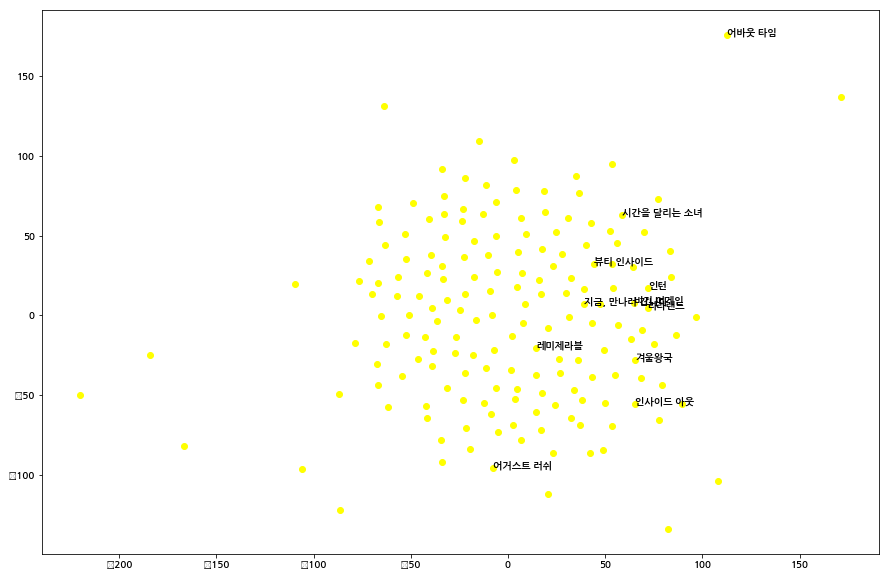

In [91]:
print('134963 = ', idx2movie['134963'])

plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_134963')] + ['MOVIE_134963']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()

관상의 유사한 영화들은 우측 상단에 위치하고 있습니다. 

93728 =  관상


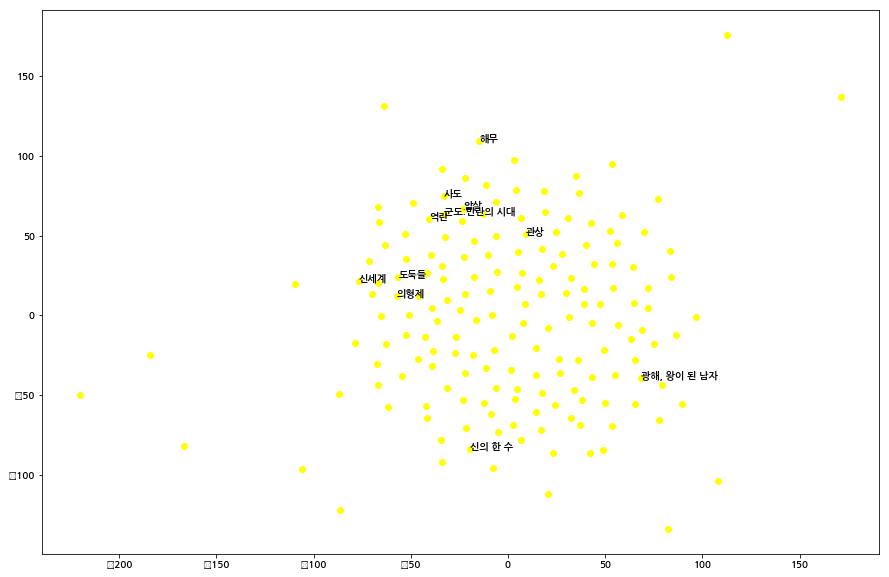

In [92]:
print('93728 = ', idx2movie['93728'])

plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_93728')] + ['MOVIE_93728']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()

액션적인 요소가 많았던 영화들은 앞선 라라랜드나 비긴어게인과 같은 영화들과는 떨어져서, 액션 영화들끼리 뭉쳐있음을 확인할 수 있습니다

62266 =  아바타


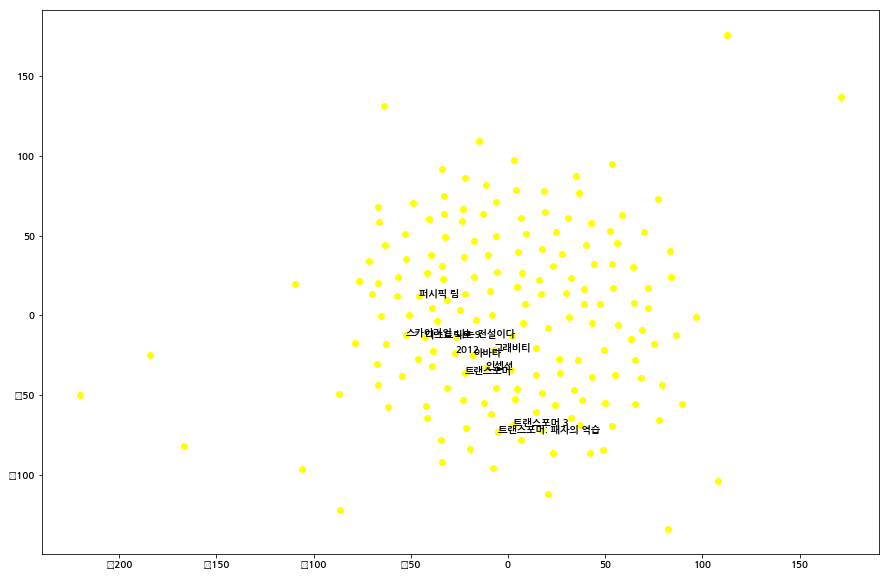

In [93]:
print('62266 = ', idx2movie['62266'])

plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')

similars = [tag for tag, _ in doc2vec_model.docvecs.most_similar('MOVIE_62266')] + ['MOVIE_62266']

for tag in similars:
    index = tag2index.get(tag, -1)
    if index == -1:
        continue
    name = index2name[index]
    plt.annotate(name, (y_tsne[index, 0], y_tsne[index, 1]))

plt.show()